## Using Large Language Model with Category Descriptions for Categorization

### Set OPENAI_API_KEY before running jupyter
You need an API key set up from: https://platform.openai.com/account/api-keys

    export OPENAI_API_KEY="secret key from site"

In [1]:
import sys
print (sys.version)

3.10.11 (main, Apr  5 2023, 14:15:30) [GCC 7.5.0]


Log into openai with OPEN_API_KEY

In [2]:
import os
import openai

# get API key from top-right dropdown on OpenAI website
openai.api_key = os.getenv("OPENAI_API_KEY") or "OPENAI_API_KEY"

# openai.Engine.list()  # check we have authenticated

## Read FPI Data
### Key Imports

In [3]:
import pandas as pd
import numpy as np

### Import our Labeled Text into a DataFrame

In [4]:
# Read the CSV File into a dataframe

labeled_data = pd.read_csv('Federal_Program_Inventory_Pilot_Data.csv',encoding='cp1252',
                           usecols=['Agency','Program Name','Program Description','Mission/Purpose',
                                    'Recipients','Beneficiaries','Associated Categories'])

# Remove duplicate rows
labeled_data = labeled_data.drop_duplicates().reset_index(drop=True)

# Get the categories
categories = pd.read_csv('Federal_Program_Inventory_Pilot_Data.csv',encoding='cp1252',
                         usecols=['Category'])
categories = categories.drop_duplicates().reset_index(drop=True)
categories = [r["Category"] for _, r in categories.iterrows()]
categories

['Broadband',
 'Economic Development',
 'Opioid Epidemic Response',
 'STEM Education',
 'Workforce Development',
 'Native American',
 'Flood Risk',
 'A.I. R&D/Quantum R&D',
 'Global Health',
 'Homelessness',
 'HIV/AIDS',
 'Transportation Infrastructure']

### Let's create our comparison string and our category list

In [5]:
# Let's join the Agency, Program Name, Program Description, Mission/Purpose, and Beneficiaries
# into a single Text field (make it human readable for the LLM)
labeled_data['text'] = ("Program Name: " + labeled_data['Program Name'] + "\n" +
                        "Agency: " + labeled_data['Agency'] + "\n" +
                        "Mission/Purpose: " + labeled_data['Mission/Purpose'] + "\n" +
                        "Program Description: " + labeled_data['Program Description'] + "\n" +
                        "Recipients: " + labeled_data['Recipients'] + "\n" +
                        "Beneficiaries: " + labeled_data['Beneficiaries'])

# Let's generate the list of categories for each entry
labeled_data['categories'] = labeled_data['Associated Categories'].str.split('; ')

In [6]:
print(labeled_data['text'][2])

Program Name: POWER Initiative
Agency: Appalachian Regional Commission
Mission/Purpose: Area and regional development
Program Description: The POWER (Partnerships for Opportunity and Workforce and Economic Revitalization) Initiative helps communities and regions that have been affected by job losses in coal mining, coal power plant operations, and coal-related supply chain industries due to the changing economics of America’s energy production. The POWER Initiative funds projects that cultivate economic diversity, enhance job training and re-employment opportunities, create jobs in existing or new industries, attract new sources of investment, and strengthen the Region’s broadband infrastructure.
Recipients: U.S. State Government (including the District of Columbia); Public/State Controlled Institution; Nonprofit with 501(c)(3) Status; Domestic Local Government (includes territories unless otherwise specified)
Beneficiaries: State; Rural; Other public institution/organization; Public n

In [7]:
# Set up arrays of labeled data and calculate the embeddings
labeled_text = labeled_data['text'].tolist()
labeled_categories = labeled_data['categories'].tolist()

In [167]:
# Import category descriptions
cat_desc_data = pd.read_csv('FPI_Category_Descriptions.csv',encoding='utf-8',
                           usecols=['Category','Description'])
# Redefine categories and category description
categories = cat_desc_data['Category'].tolist()
category_descriptions = cat_desc_data['Description'].tolist()
categories


['Broadband',
 'Economic Development',
 'Opioid Epidemic Response',
 'STEM Education',
 'Workforce Development',
 'Native American',
 'Flood Risk',
 'A.I. R&D/Quantum R&D',
 'Global Health',
 'Homelessness',
 'HIV/AIDS',
 'Transportation Infrastructure']

## Let's try to conduct a query using the Broadband description

In [169]:
key = 45
print(labeled_text[key])
print(labeled_categories[key])

Program Name: APHIS - AgDiscovery
Agency: Department of Agriculture
Mission/Purpose: Agricultural research and services
Program Description: AgDiscovery is a unique opportunity for students to explore agricultural sciences, and gain knowledge about careers in animal and plant disciplines, wildlife management, veterinary medicine, biotechnology, entomology, food safety, food production, agribusiness, forestry, and much more. Students experience hands-on learning workshops, behind-the-scenes tours, laboratory and field exercises, in addition to a variety of cultural and teambuilding activities.
Recipients: Public/State Controlled Institution
Beneficiaries: Education (9-12); Youth (16-21)
['STEM Education']


In [176]:
# Let's try a to search our index!
cat_idx = 3
category = categories[cat_idx]
cat_description = category_descriptions[cat_idx]

In [177]:
query = ("You are a Resrouce Management Officer in the US Federal Office of Management and Budget.\n" +
         "Your goal is to analyze program descriptions and determine the probability that they fit\n" +
         "into specific categories.\n\n" +
         f"You are currently considering the '{category}' category with the following definition: " + "\n\n" +
         cat_description + "\n\n" +
         f"Please determine the probability of assigning the '{category}' category to the following program description: " + "\n\n" +
         labeled_text[key] + "\n\n" +
          "Output a JSON object (do not output any other text) with four entries: \n" +
          " 1) 'clues' First, list CLUES (i.e. Keywords, phrases, contextual information, semantic relations, semantic meaning, tones, references) from the program description that match the category definition\n" + 
          " 2) 'reasoning' Second, deduce the diagnostic REASONING process from premises (i.e., clues, input) that supports the program categorization\n" + 
          f" 3) 'probability' Third, estimate the probability (a fraction between 0 and 1) that the program is in the '{category}' category")

print(query)

You are a Resrouce Management Officer in the US Federal Office of Management and Budget.
Your goal is to analyze program descriptions and determine the probability that they fit
into specific categories.

You are currently considering the 'STEM Education' category with the following definition: 

STEM Education programs are programs that provide formal or informal (in school or out) education that is primarily focused on Science Technology Engineering and Math (STEM) disciplines, topics, or issues, as defined below. STEM disciplines include physical and natural sciences, technology, engineering, mathematics, and computer science disciplines, topics, or issues (including environmental science, environmental stewardship, and cybersecurity).

Please determine the probability of assigning the 'STEM Education' category to the following program description: 

Program Name: APHIS - AgDiscovery
Agency: Department of Agriculture
Mission/Purpose: Agricultural research and services
Program Descri

In [178]:
# now query GPT 4
chat = openai.ChatCompletion.create(
    model='gpt-4',
    temperature=0,
    n=1,
    messages=[
        {"role": "user", "content" : query}
    ]
)

#print(chat['choices'][0]['message']['content'])
print('\n\n'.join([c['message']['content'] for c in chat['choices']]))

{
  "clues": [
    "explore agricultural sciences",
    "careers in animal and plant disciplines",
    "wildlife management",
    "veterinary medicine",
    "biotechnology",
    "entomology",
    "food safety",
    "food production",
    "agribusiness",
    "forestry",
    "hands-on learning workshops",
    "laboratory and field exercises",
    "Education (9-12)",
    "Youth (16-21)"
  ],
  "reasoning": "The program description includes several references to scientific disciplines such as agricultural sciences, biotechnology, entomology, and veterinary medicine. It also mentions hands-on learning workshops and laboratory and field exercises, which are indicative of a STEM education program. Furthermore, the beneficiaries of the program are students in the 9-12 age group and youth aged 16-21, which is a typical target audience for STEM education programs.",
  "probability": 0.9
}


In [179]:
labeled_categories[key]

['STEM Education']

In [181]:
import json

def llm_get_probability_from_desc(key, category, cat_description, temperature=0, model='gpt-4'):
    query = ("You are a Resrouce Management Officer in the US Federal Office of Management and Budget.\n" +
             "Your goal is to analyze program descriptions and determine the probability that they fit\n" +
             "into specific categories.\n\n" +
             f"You are currently considering the '{category}' category with the following definition: " + "\n\n" +
             cat_description + "\n\n" +
             f"Please determine the probability of assigning the '{category}' category to the following program description: " + "\n\n" +
             labeled_text[key] + "\n\n" +
              "Output a JSON object (do not output any other text) with four entries: \n" +
              " 1) 'clues' First, list CLUES (i.e. Keywords, phrases, contextual information, semantic relations, semantic meaning, tones, references) from the program description that match the category definition\n" + 
              " 2) 'reasoning' Second, deduce the diagnostic REASONING process from premises (i.e., clues, input) that supports the program categorization\n" + 
              f" 3) 'probability' Third, estimate the probability (a fraction between 0 and 1) that the program is in the '{category}' category")
    # print(query)
    chat = openai.ChatCompletion.create(
        model=model,
        temperature=temperature,
        messages=[{"role": "user", "content": query}]
    )
    return(json.loads(chat['choices'][0]['message']['content']))

In [182]:
llm_get_probability_from_desc(key, category, cat_description)

{'clues': ['explore agricultural sciences',
  'careers in animal and plant disciplines',
  'wildlife management',
  'veterinary medicine',
  'biotechnology',
  'entomology',
  'food safety',
  'food production',
  'agribusiness',
  'forestry',
  'hands-on learning workshops',
  'laboratory and field exercises',
  'Education (9-12)',
  'Youth (16-21)'],
 'reasoning': 'The program description includes several references to scientific disciplines such as agricultural sciences, biotechnology, entomology, and veterinary medicine. It also mentions hands-on learning workshops and laboratory and field exercises, which are indicative of a STEM education program. Furthermore, the beneficiaries of the program are students in the 9-12 age group and youth aged 16-21, which is consistent with the target demographic for STEM education programs.',
 'probability': 0.9}

## Sample the categories
For each category we want to find 100 programs, up to 50 in the category and the rest out.

In [238]:
total_samples = 100
max_true_samples = int(total_samples/2)
# Location to store our chosen indices
cat_sample_idxs = []
for i in range(0,len(categories)):
    category = categories[i]
    in_cat = [(category in lc) for lc in labeled_categories]
    true_idxs = [key for key, value in enumerate(in_cat) if value]
    false_idxs = [key for key, value in enumerate(in_cat) if not(value)]
    # Count and limit true samples to half of total_samples
    true_sample_count = min(len(true_idxs),max_true_samples)
    false_sample_count = total_samples - true_sample_count
    # Randomly pick true and false samples without replacement (so each index is unique)
    true_sample_idxs = np.random.choice(true_idxs, size=true_sample_count, replace=False)
    false_sample_idxs = np.random.choice(false_idxs, size=false_sample_count, replace=False)
    # Now join and sort them
    sample_idxs = []
    sample_idxs.extend(true_sample_idxs)
    sample_idxs.extend(false_sample_idxs)
    sample_idxs.sort()
    # Add it to our list of chosen indexes
    cat_sample_idxs.append(sample_idxs)
    
    print(f"{category}: We have {len(true_sample_idxs)} trues and {len(false_sample_idxs)} falses Total {len(sample_idxs)}")


Broadband: We have 37 trues and 63 falses Total 100
Economic Development: We have 45 trues and 55 falses Total 100
Opioid Epidemic Response: We have 46 trues and 54 falses Total 100
STEM Education: We have 50 trues and 50 falses Total 100
Workforce Development: We have 50 trues and 50 falses Total 100
Native American: We have 50 trues and 50 falses Total 100
Flood Risk: We have 45 trues and 55 falses Total 100
A.I. R&D/Quantum R&D: We have 50 trues and 50 falses Total 100
Global Health: We have 25 trues and 75 falses Total 100
Homelessness: We have 33 trues and 67 falses Total 100
HIV/AIDS: We have 25 trues and 75 falses Total 100
Transportation Infrastructure: We have 42 trues and 58 falses Total 100


In [241]:
# Store all of our probabilities (start with one empty list per category)
found_probabilities=[ [] for _ in range(0, len(categories)) ]
if os.path.exists("found_probabilities.json"):
    with open("found_probabilities.json","r") as infile:
        found_categories = json.load(infile)
        
# found_categories

In [242]:
import time

# The following is a reentrant loop so that we can calculate the categories for all of the FPI programs
# in batches
error_count = 0
for cat_idx in range(0,len(categories)):
    category = categories[cat_idx]
    cat_description = category_descriptions[cat_idx]
    for i in range(0,len(cat_sample_idxs[cat_idx])):
        if (i >= len(found_probabilities[cat_idx])):
            while True:
                try:
                    sample_idx = cat_sample_idxs[cat_idx][i] 
                    chat_result = llm_get_probability_from_desc(sample_idx, category, cat_description, error_count * 0.1)
                    error_count = 0
                    break
                except Exception as e:
                    print(e)
                    error_count += 1
                    if error_count > 3:
                        raise Exception("Three errors in a row")
                    time.sleep(5)
            chat_result["key"] = int(sample_idx) # Record key just in case
            # print(chat_result)
            print(f"{cat_idx} - {i} - {sample_idx}")
            found_probabilities[cat_idx].append(chat_result)
            with open("found_probabilities.json","w") as outfile:
                outfile.write(json.dumps(found_probabilities))
   

0 - 0 - 0
0 - 1 - 2
0 - 2 - 3
0 - 3 - 8
0 - 4 - 9
0 - 5 - 20
0 - 6 - 27
0 - 7 - 31
0 - 8 - 32
0 - 9 - 50
0 - 10 - 52
0 - 11 - 54
0 - 12 - 65
0 - 13 - 67
0 - 14 - 71
0 - 15 - 79
0 - 16 - 80
0 - 17 - 86
0 - 18 - 113
0 - 19 - 114
0 - 20 - 115
0 - 21 - 118
0 - 22 - 119
0 - 23 - 120
0 - 24 - 121
0 - 25 - 122
0 - 26 - 123
0 - 27 - 133
0 - 28 - 138
0 - 29 - 145
0 - 30 - 151
0 - 31 - 152
0 - 32 - 153
0 - 33 - 154
0 - 34 - 156
0 - 35 - 190
0 - 36 - 199
0 - 37 - 206
0 - 38 - 207
0 - 39 - 210
0 - 40 - 219
0 - 41 - 223
0 - 42 - 224
0 - 43 - 231
0 - 44 - 240
0 - 45 - 244
0 - 46 - 254
0 - 47 - 257
0 - 48 - 259
0 - 49 - 263
0 - 50 - 312
0 - 51 - 328
0 - 52 - 338
0 - 53 - 340
0 - 54 - 361
0 - 55 - 365
0 - 56 - 393
0 - 57 - 402
0 - 58 - 411
0 - 59 - 413
0 - 60 - 417
0 - 61 - 426
0 - 62 - 428
0 - 63 - 439
0 - 64 - 446
0 - 65 - 449
0 - 66 - 453
0 - 67 - 468
0 - 68 - 485
0 - 69 - 489
0 - 70 - 493
0 - 71 - 494
0 - 72 - 496
0 - 73 - 502
0 - 74 - 522
0 - 75 - 532
0 - 76 - 535
0 - 77 - 563
0 - 78 - 570
0 - 79

6 - 49 - 282
6 - 50 - 283
6 - 51 - 290
6 - 52 - 298
6 - 53 - 302
6 - 54 - 309
6 - 55 - 314
6 - 56 - 316
6 - 57 - 355
6 - 58 - 357
6 - 59 - 358
6 - 60 - 359
6 - 61 - 368
6 - 62 - 377
6 - 63 - 378
6 - 64 - 391
6 - 65 - 392
6 - 66 - 394
6 - 67 - 423
6 - 68 - 450
6 - 69 - 454
6 - 70 - 458
6 - 71 - 459
6 - 72 - 465
6 - 73 - 475
6 - 74 - 480
6 - 75 - 484
6 - 76 - 488
6 - 77 - 499
6 - 78 - 507
6 - 79 - 508
6 - 80 - 521
6 - 81 - 539
6 - 82 - 541
6 - 83 - 545
6 - 84 - 546
6 - 85 - 560
6 - 86 - 570
6 - 87 - 575
6 - 88 - 580
6 - 89 - 596
6 - 90 - 609
6 - 91 - 610
6 - 92 - 623
6 - 93 - 640
6 - 94 - 655
6 - 95 - 657
6 - 96 - 659
6 - 97 - 660
6 - 98 - 685
6 - 99 - 710
7 - 0 - 36
7 - 1 - 42
7 - 2 - 48
7 - 3 - 54
7 - 4 - 78
7 - 5 - 87
7 - 6 - 101
7 - 7 - 110
7 - 8 - 111
7 - 9 - 115
7 - 10 - 124
7 - 11 - 125
7 - 12 - 127
7 - 13 - 129
7 - 14 - 131
7 - 15 - 132
7 - 16 - 137
7 - 17 - 140
7 - 18 - 145
7 - 19 - 146
7 - 20 - 151
7 - 21 - 202
7 - 22 - 203
7 - 23 - 204
7 - 24 - 205
7 - 25 - 206
7 - 26 - 207
7 

In [243]:
# found_probabilities

Broadband
    Threshold  True Pos  Accuracy  Precision    Recall        F1
0        0.00        37      0.37   0.370000  1.000000  0.540146
1        0.05        28      0.90   0.965517  0.756757  0.848485
2        0.10        28      0.90   0.965517  0.756757  0.848485
3        0.15        28      0.90   0.965517  0.756757  0.848485
4        0.20        28      0.90   0.965517  0.756757  0.848485
5        0.25        27      0.90   1.000000  0.729730  0.843750
6        0.30        27      0.90   1.000000  0.729730  0.843750
7        0.35        26      0.89   1.000000  0.702703  0.825397
8        0.40        26      0.89   1.000000  0.702703  0.825397
9        0.45        25      0.88   1.000000  0.675676  0.806452
10       0.50        25      0.88   1.000000  0.675676  0.806452
11       0.55        25      0.88   1.000000  0.675676  0.806452
12       0.60        25      0.88   1.000000  0.675676  0.806452
13       0.65        25      0.88   1.000000  0.675676  0.806452
14       0.70  

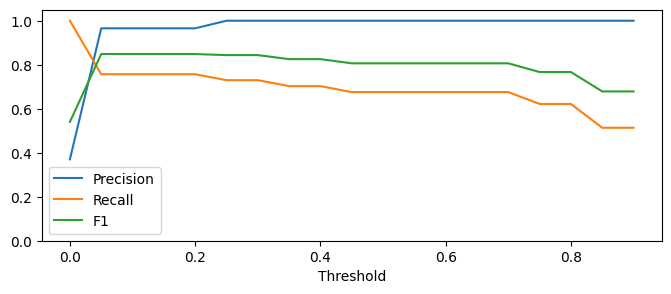

Economic Development
    Threshold  True Pos  Accuracy  Precision    Recall        F1
0        0.00        45      0.45   0.450000  1.000000  0.620690
1        0.05        44      0.79   0.687500  0.977778  0.807339
2        0.10        44      0.79   0.687500  0.977778  0.807339
3        0.15        44      0.82   0.721311  0.977778  0.830189
4        0.20        44      0.82   0.721311  0.977778  0.830189
5        0.25        44      0.86   0.771930  0.977778  0.862745
6        0.30        44      0.86   0.771930  0.977778  0.862745
7        0.35        44      0.89   0.814815  0.977778  0.888889
8        0.40        44      0.89   0.814815  0.977778  0.888889
9        0.45        42      0.92   0.893617  0.933333  0.913043
10       0.50        42      0.92   0.893617  0.933333  0.913043
11       0.55        42      0.92   0.893617  0.933333  0.913043
12       0.60        42      0.92   0.893617  0.933333  0.913043
13       0.65        37      0.90   0.948718  0.822222  0.880952
14  

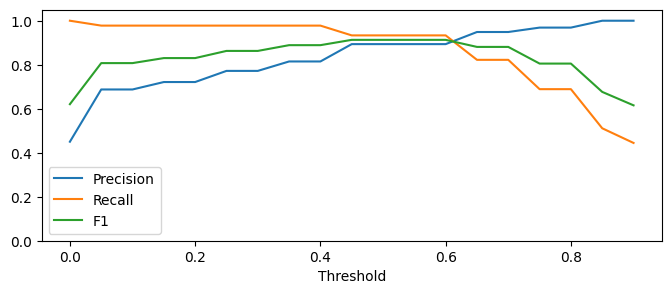

Opioid Epidemic Response
    Threshold  True Pos  Accuracy  Precision    Recall        F1
0        0.00        46      0.46   0.460000  1.000000  0.630137
1        0.05        39      0.88   0.886364  0.847826  0.866667
2        0.10        39      0.88   0.886364  0.847826  0.866667
3        0.15        38      0.88   0.904762  0.826087  0.863636
4        0.20        38      0.88   0.904762  0.826087  0.863636
5        0.25        37      0.88   0.925000  0.804348  0.860465
6        0.30        37      0.88   0.925000  0.804348  0.860465
7        0.35        36      0.88   0.947368  0.782609  0.857143
8        0.40        36      0.88   0.947368  0.782609  0.857143
9        0.45        36      0.89   0.972973  0.782609  0.867470
10       0.50        36      0.89   0.972973  0.782609  0.867470
11       0.55        34      0.88   1.000000  0.739130  0.850000
12       0.60        34      0.88   1.000000  0.739130  0.850000
13       0.65        29      0.83   1.000000  0.630435  0.773333


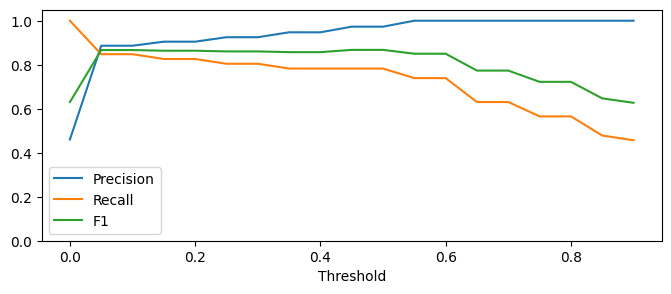

STEM Education
    Threshold  True Pos  Accuracy  Precision  Recall        F1
0        0.00        50      0.50   0.500000    1.00  0.666667
1        0.05        44      0.83   0.800000    0.88  0.838095
2        0.10        44      0.83   0.800000    0.88  0.838095
3        0.15        44      0.85   0.830189    0.88  0.854369
4        0.20        44      0.85   0.830189    0.88  0.854369
5        0.25        40      0.83   0.851064    0.80  0.824742
6        0.30        40      0.83   0.851064    0.80  0.824742
7        0.35        38      0.82   0.863636    0.76  0.808511
8        0.40        38      0.82   0.863636    0.76  0.808511
9        0.45        38      0.83   0.883721    0.76  0.817204
10       0.50        38      0.83   0.883721    0.76  0.817204
11       0.55        38      0.83   0.883721    0.76  0.817204
12       0.60        38      0.83   0.883721    0.76  0.817204
13       0.65        38      0.85   0.926829    0.76  0.835165
14       0.70        38      0.85   0.92

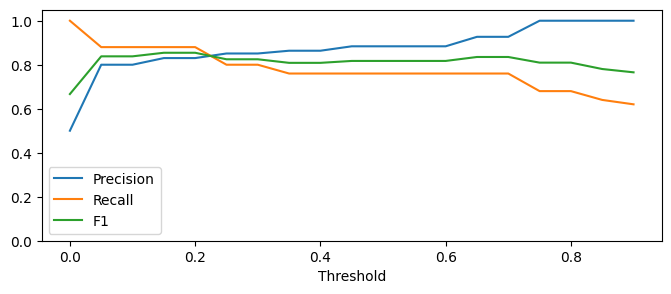

Workforce Development
    Threshold  True Pos  Accuracy  Precision  Recall        F1
0        0.00        50      0.50   0.500000    1.00  0.666667
1        0.05        46      0.77   0.707692    0.92  0.800000
2        0.10        46      0.77   0.707692    0.92  0.800000
3        0.15        45      0.78   0.725806    0.90  0.803571
4        0.20        45      0.78   0.725806    0.90  0.803571
5        0.25        45      0.81   0.762712    0.90  0.825688
6        0.30        45      0.81   0.762712    0.90  0.825688
7        0.35        44      0.82   0.785714    0.88  0.830189
8        0.40        44      0.82   0.785714    0.88  0.830189
9        0.45        40      0.80   0.800000    0.80  0.800000
10       0.50        40      0.80   0.800000    0.80  0.800000
11       0.55        39      0.79   0.795918    0.78  0.787879
12       0.60        39      0.79   0.795918    0.78  0.787879
13       0.65        36      0.81   0.878049    0.72  0.791209
14       0.70        36      0.81

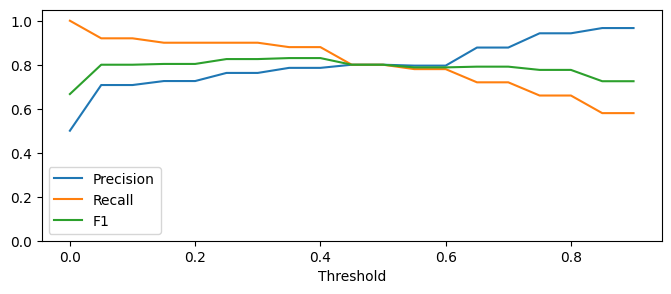

Native American
    Threshold  True Pos  Accuracy  Precision  Recall        F1
0        0.00        50      0.50   0.500000    1.00  0.666667
1        0.05        46      0.79   0.730159    0.92  0.814159
2        0.10        46      0.79   0.730159    0.92  0.814159
3        0.15        45      0.80   0.750000    0.90  0.818182
4        0.20        45      0.80   0.750000    0.90  0.818182
5        0.25        45      0.80   0.750000    0.90  0.818182
6        0.30        45      0.80   0.750000    0.90  0.818182
7        0.35        45      0.81   0.762712    0.90  0.825688
8        0.40        45      0.81   0.762712    0.90  0.825688
9        0.45        45      0.81   0.762712    0.90  0.825688
10       0.50        45      0.81   0.762712    0.90  0.825688
11       0.55        43      0.82   0.796296    0.86  0.826923
12       0.60        43      0.82   0.796296    0.86  0.826923
13       0.65        43      0.82   0.796296    0.86  0.826923
14       0.70        43      0.82   0.7

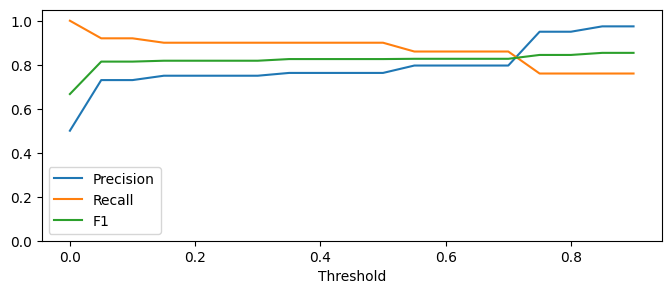

Flood Risk
    Threshold  True Pos  Accuracy  Precision    Recall        F1
0        0.00        45      0.45   0.450000  1.000000  0.620690
1        0.05        35      0.89   0.972222  0.777778  0.864198
2        0.10        35      0.89   0.972222  0.777778  0.864198
3        0.15        34      0.88   0.971429  0.755556  0.850000
4        0.20        34      0.88   0.971429  0.755556  0.850000
5        0.25        32      0.86   0.969697  0.711111  0.820513
6        0.30        32      0.86   0.969697  0.711111  0.820513
7        0.35        28      0.82   0.965517  0.622222  0.756757
8        0.40        28      0.82   0.965517  0.622222  0.756757
9        0.45        26      0.80   0.962963  0.577778  0.722222
10       0.50        26      0.80   0.962963  0.577778  0.722222
11       0.55        25      0.79   0.961538  0.555556  0.704225
12       0.60        25      0.79   0.961538  0.555556  0.704225
13       0.65        22      0.76   0.956522  0.488889  0.647059
14       0.70 

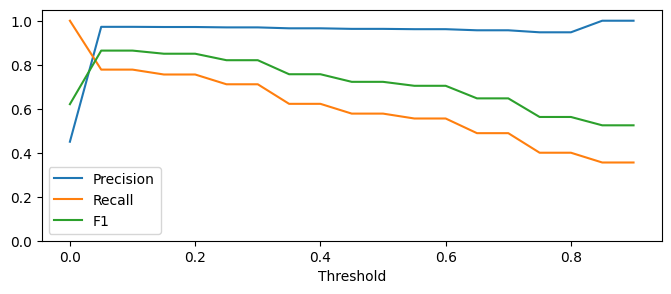

A.I. R&D/Quantum R&D
    Threshold  True Pos  Accuracy  Precision  Recall        F1
0        0.00        50      0.50   0.500000    1.00  0.666667
1        0.05        32      0.78   0.888889    0.64  0.744186
2        0.10        32      0.78   0.888889    0.64  0.744186
3        0.15        30      0.78   0.937500    0.60  0.731707
4        0.20        30      0.78   0.937500    0.60  0.731707
5        0.25        29      0.78   0.966667    0.58  0.725000
6        0.30        29      0.78   0.966667    0.58  0.725000
7        0.35        23      0.73   1.000000    0.46  0.630137
8        0.40        23      0.73   1.000000    0.46  0.630137
9        0.45        22      0.72   1.000000    0.44  0.611111
10       0.50        22      0.72   1.000000    0.44  0.611111
11       0.55        17      0.67   1.000000    0.34  0.507463
12       0.60        17      0.67   1.000000    0.34  0.507463
13       0.65        15      0.65   1.000000    0.30  0.461538
14       0.70        15      0.65 

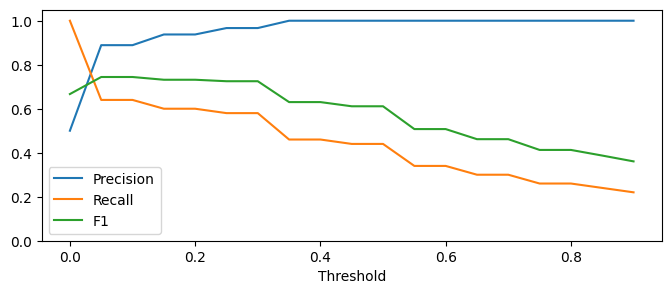

Global Health
    Threshold  True Pos  Accuracy  Precision  Recall        F1
0        0.00        25      0.25   0.250000    1.00  0.400000
1        0.05        25      0.95   0.833333    1.00  0.909091
2        0.10        25      0.95   0.833333    1.00  0.909091
3        0.15        25      0.97   0.892857    1.00  0.943396
4        0.20        25      0.97   0.892857    1.00  0.943396
5        0.25        25      0.99   0.961538    1.00  0.980392
6        0.30        25      0.99   0.961538    1.00  0.980392
7        0.35        25      0.99   0.961538    1.00  0.980392
8        0.40        25      0.99   0.961538    1.00  0.980392
9        0.45        25      0.99   0.961538    1.00  0.980392
10       0.50        25      0.99   0.961538    1.00  0.980392
11       0.55        25      1.00   1.000000    1.00  1.000000
12       0.60        25      1.00   1.000000    1.00  1.000000
13       0.65        25      1.00   1.000000    1.00  1.000000
14       0.70        25      1.00   1.000

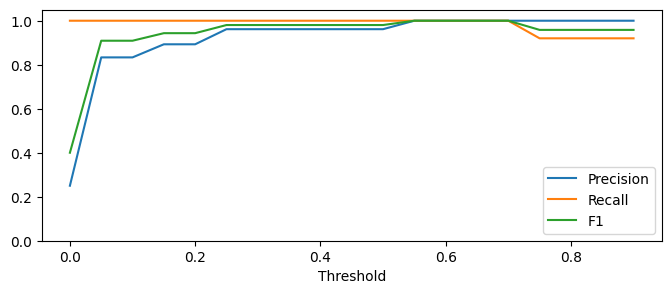

Homelessness
    Threshold  True Pos  Accuracy  Precision    Recall        F1
0        0.00        33      0.33   0.330000  1.000000  0.496241
1        0.05        30      0.94   0.909091  0.909091  0.909091
2        0.10        30      0.94   0.909091  0.909091  0.909091
3        0.15        30      0.94   0.909091  0.909091  0.909091
4        0.20        30      0.94   0.909091  0.909091  0.909091
5        0.25        29      0.93   0.906250  0.878788  0.892308
6        0.30        29      0.93   0.906250  0.878788  0.892308
7        0.35        28      0.92   0.903226  0.848485  0.875000
8        0.40        28      0.92   0.903226  0.848485  0.875000
9        0.45        28      0.93   0.933333  0.848485  0.888889
10       0.50        28      0.93   0.933333  0.848485  0.888889
11       0.55        28      0.95   1.000000  0.848485  0.918033
12       0.60        28      0.95   1.000000  0.848485  0.918033
13       0.65        27      0.94   1.000000  0.818182  0.900000
14       0.7

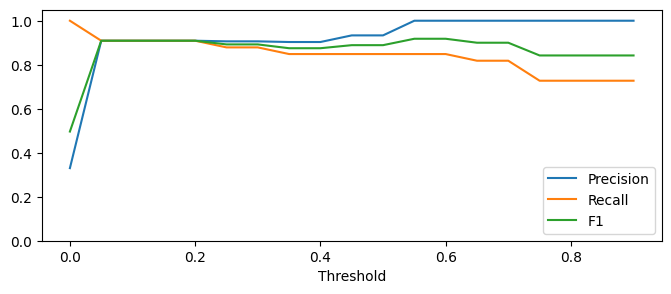

HIV/AIDS
    Threshold  True Pos  Accuracy  Precision  Recall        F1
0        0.00        25      0.25   0.250000    1.00  0.400000
1        0.05        24      0.97   0.923077    0.96  0.941176
2        0.10        24      0.97   0.923077    0.96  0.941176
3        0.15        23      0.97   0.958333    0.92  0.938776
4        0.20        23      0.97   0.958333    0.92  0.938776
5        0.25        22      0.96   0.956522    0.88  0.916667
6        0.30        22      0.96   0.956522    0.88  0.916667
7        0.35        22      0.96   0.956522    0.88  0.916667
8        0.40        22      0.96   0.956522    0.88  0.916667
9        0.45        22      0.96   0.956522    0.88  0.916667
10       0.50        22      0.96   0.956522    0.88  0.916667
11       0.55        22      0.96   0.956522    0.88  0.916667
12       0.60        22      0.96   0.956522    0.88  0.916667
13       0.65        22      0.96   0.956522    0.88  0.916667
14       0.70        22      0.96   0.956522  

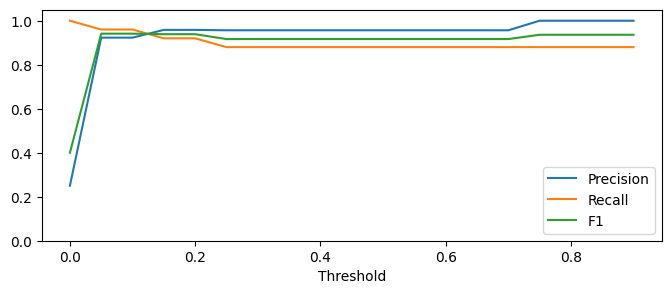

Transportation Infrastructure
    Threshold  True Pos  Accuracy  Precision    Recall        F1
0        0.00        42      0.42   0.420000  1.000000  0.591549
1        0.05        42      0.96   0.913043  1.000000  0.954545
2        0.10        42      0.96   0.913043  1.000000  0.954545
3        0.15        42      0.97   0.933333  1.000000  0.965517
4        0.20        42      0.97   0.933333  1.000000  0.965517
5        0.25        42      0.98   0.954545  1.000000  0.976744
6        0.30        42      0.98   0.954545  1.000000  0.976744
7        0.35        42      0.99   0.976744  1.000000  0.988235
8        0.40        42      0.99   0.976744  1.000000  0.988235
9        0.45        42      1.00   1.000000  1.000000  1.000000
10       0.50        42      1.00   1.000000  1.000000  1.000000
11       0.55        42      1.00   1.000000  1.000000  1.000000
12       0.60        42      1.00   1.000000  1.000000  1.000000
13       0.65        42      1.00   1.000000  1.000000  1.00

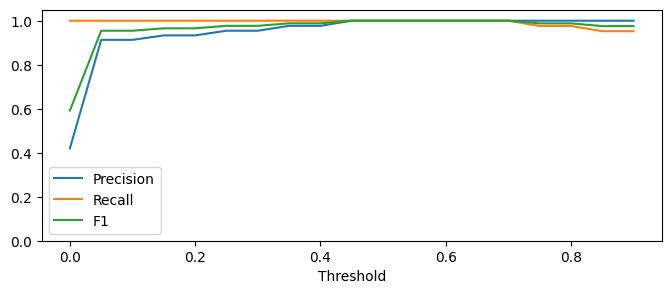

In [250]:
import matplotlib.pyplot as mp

# Calculate and display Accuracy, Precision, and Recall for each threshold
for cat_idx in range(0,len(categories)):
    category = categories[cat_idx]
    precision_data = []
    sample_idxs = cat_sample_idxs[cat_idx]
    if len(found_probabilities[cat_idx]) < total_samples:
        continue
    for t in range(0,19):
        in_cat = [(category in labeled_categories[si]) for si in sample_idxs]
        assigned_cat = [(fp["probability"] * 20 >= t) for fp in found_probabilities[cat_idx]]
        tp = ([(a and b) for a, b in zip(in_cat, assigned_cat)]).count(True)
        tn = ([(not(a) and not(b)) for a, b in zip(in_cat, assigned_cat)]).count(True)
        fp = ([(not(a) and b) for a, b in zip(in_cat, assigned_cat)]).count(True)
        fn = ([(a and not(b)) for a, b in zip(in_cat, assigned_cat)]).count(True)
        accuracy = (tp+tn)/(tp+tn+fp+fn)
        if (tp+fp > 0):
            precision = tp/(tp + fp)
        else:
            precision = 0
        if (tp+fn > 0):
            recall = tp/(tp + fn)
        else:
            recall = 0
        if (precision > 0 and recall > 0):
            f1 = 2.0 / ((1/precision) + (1/recall))
        else:
            f1 = 0
#        precision_data.append([t / 20.0,tp,tn,fp,fn,accuracy,precision,recall,f1])
        precision_data.append([t / 20.0,tp,accuracy,precision,recall,f1])

#    df = pd.DataFrame(precision_data, columns = ['Threshold','True Pos','True Neg','False Pos',
#                                                 'False Neg','Accuracy','Precision','Recall','F1'])
    df = pd.DataFrame(precision_data, columns = ['Threshold','True Pos','Accuracy','Precision','Recall','F1'])
    print(category)
    print(df)
    # plot the dataframe
    df.plot(x="Threshold", y=["Precision", "Recall", "F1"], ylim=(0,1.05), figsize=(8,3), kind="line")
 
    # print bar graph
    mp.show()

    Threshold  True Pos  Accuracy  Precision    Recall        F1
0        0.00       498  0.415000   0.415000  1.000000  0.586572
1        0.05       435  0.870833   0.825427  0.873494  0.848780
2        0.10       435  0.870833   0.825427  0.873494  0.848780
3        0.15       428  0.878333   0.849206  0.859438  0.854291
4        0.20       428  0.878333   0.849206  0.859438  0.854291
5        0.25       417  0.881667   0.872385  0.837349  0.854508
6        0.30       417  0.881667   0.872385  0.837349  0.854508
7        0.35       401  0.876667   0.887168  0.805221  0.844211
8        0.40       401  0.876667   0.887168  0.805221  0.844211
9        0.45       391  0.877500   0.907193  0.785141  0.841765
10       0.50       391  0.877500   0.907193  0.785141  0.841765
11       0.55       380  0.874167   0.920097  0.763052  0.834248
12       0.60       380  0.874167   0.920097  0.763052  0.834248
13       0.65       361  0.866667   0.940104  0.724900  0.818594
14       0.70       361  

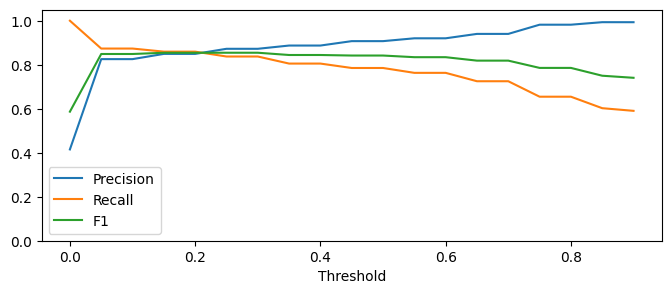

In [252]:
# Calculate and display Accuracy, Precision, and Recall for each threshold over all categories
precision_data = []
for t in range(0,19):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for cat_idx in range(0,len(categories)):
        category = categories[cat_idx]
        sample_idxs = cat_sample_idxs[cat_idx]
        if len(found_probabilities[cat_idx]) < total_samples:
            continue
        in_cat = [(category in labeled_categories[si]) for si in sample_idxs]
        assigned_cat = [(fp["probability"] * 20 >= t) for fp in found_probabilities[cat_idx]]
        tp += ([(a and b) for a, b in zip(in_cat, assigned_cat)]).count(True)
        tn += ([(not(a) and not(b)) for a, b in zip(in_cat, assigned_cat)]).count(True)
        fp += ([(not(a) and b) for a, b in zip(in_cat, assigned_cat)]).count(True)
        fn += ([(a and not(b)) for a, b in zip(in_cat, assigned_cat)]).count(True)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    if (tp+fp > 0):
        precision = tp/(tp + fp)
    else:
        precision = 0
    if (tp+fn > 0):
        recall = tp/(tp + fn)
    else:
        recall = 0
    if (precision > 0 and recall > 0):
        f1 = 2.0 / ((1/precision) + (1/recall))
    else:
        f1 = 0
#        precision_data.append([t / 20.0,tp,tn,fp,fn,accuracy,precision,recall,f1])
    precision_data.append([t / 20.0,tp,accuracy,precision,recall,f1])

df = pd.DataFrame(precision_data, columns = ['Threshold','True Pos','Accuracy','Precision','Recall','F1'])
print(df)
# plot the dataframe
df.plot(x="Threshold", y=["Precision", "Recall", "F1"], ylim=(0,1.05), figsize=(8,3), kind="line")

# print bar graph
mp.show()

In [139]:
# Export key information to a spreadsheet for analysis
in_cat = [(category if category in lc else "") for lc in labeled_categories]
fp = [fc["probability"] for fc in found_probabilities]
fr = [fc["reasoning"] for fc in found_probabilities]
fk = [fc["clues"] if "clues" in fc else "" for fc in found_probabilities]
data = [[i, labeled_text[i], in_cat[i], fp[i], fk[i], fr[i]] for i in range(0,len(labeled_text))]
                                   
df = pd.DataFrame(data, columns = ['idx','Text','real_categories','probability','keywords','reasoning'])
df.to_csv("llm_desc_results.csv")